# some figures related to single-site emulator

In [1]:
import sys, os, glob, pickle, toml, json, pickle, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.model_selection import GroupKFold,  KFold

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax

def get_rmse(d1, d2):
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

def get_cc(d1, d2):
    ind = ~np.isnan(d1+d2)
    return np.corrcoef(d1[ind], d2[ind])[0,1]

def combine_cv_test(cv_result):
    dataplot = []
    dinput = np.array([])
    dest = np.array([])
    dindex = np.array([])
    for i in range(len(cv_result)):
        dinput = np.hstack([dinput, np.squeeze(cv_result[i]['y_test'])])
        dest = np.hstack([dest,  np.squeeze(cv_result[i]['y_test_pred'])])
        dindex = np.hstack([dindex,  np.squeeze(cv_result[i]['test_index'])])
    
    dd = np.vstack([dindex, dinput, dest]).T
    return dd

In [2]:
# load info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

In [3]:
# load data

path = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/LargeSampleEmulator_exps_out'

methods1 = ['rf', 'mlp']
methods2 = ['RF', 'MLP']
metprefix = [ ['rf', 'rf_group', ], 
             ['mlp', 'mlp_group', ]]
types = ['standard', 'group']


cv_est = []

# standard and group are 5-fold
# cluster is 15-fold because of 15 folds
cv_eval = np.nan * np.zeros([15, 2, 2, 2, 2]) # 15 clusters; rmse/cc; train/test; rf/mlp; standard/group
lab = []


for i in range(2):
    for j in range(2):
        cv_est_ij = np.zeros([0, 4])
        lab.append(f'{methods2[i]} {types[j]}')
        for c in range(15):
            
            file = f'{path}/SBE_cluster{c}_{methods2[i]}_normKGE_{types[j]}CV_estimates.pkl'
            with open(file, 'rb') as file:
                cvc = combine_cv_test(pickle.load(file))
                cvc = np.hstack([np.ones([cvc.shape[0], 1]) * c, cvc])
                cv_est_ij = np.vstack([cv_est_ij, cvc])
        
            file =  f'{path}/SBE_cluster{c}_{methods2[i]}_normKGE_{types[j]}CV_evaluation.npz'
            dtmp = np.load(file)
            cv_eval[c,0,0,i,j] = np.mean(dtmp[f'{metprefix[i][j]}_rmse_train'])
            cv_eval[c,0,1,i,j] = np.mean(dtmp[f'{metprefix[i][j]}_rmse_test'])
            cv_eval[c,1,0,i,j] = np.mean(dtmp[f'{metprefix[i][j]}_cc_train'])
            cv_eval[c,1,1,i,j] = np.mean(dtmp[f'{metprefix[i][j]}_cc_test'])

        ind = np.argsort(cv_est_ij[:,1])
        cv_est_ij = cv_est_ij[ind, :]
        cv_est.append(cv_est_ij)

cv_est = np.array(cv_est)
print(lab)
print(cv_est.shape)

['RF standard', 'RF group', 'MLP standard', 'MLP group']
(4, 124037, 4)


In [4]:
# load cluster information
infile = "../../camels_cluster/Manuela_Brunner_2020/flood_cluster_memberships_CAMELS.txt"
df_cluster = pd.read_csv(infile)
df_cluster = df_cluster.rename(
    columns={"Camels_IDs": "hru_id", "flood_cluster": "clusters"}
)
df_cluster2 = pd.DataFrame()

for id in df_info["hru_id"].values:
    dfi = df_cluster.loc[df_cluster["hru_id"] == id]
    df_cluster2 = pd.concat([df_cluster2, dfi])

df_cluster2.sel_index = np.arange(len(df_cluster2))
df_cluster = df_cluster2
del df_cluster2
df_cluster["clusters"] = df_cluster["clusters"] - 1  # starting from 0

if np.any(df_info["hru_id"].values - df_cluster['hru_id'].values != 0):
    print("Mistmatch between basins and clusters")
else:
    print("basins and clusters match")

basins and clusters match


/glade/derecho/scratch/guoqiang/tmp/ipykernel_17635/3393541547.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_cluster2.sel_index = np.arange(len(df_cluster2))


# Compare the performance of RF and MLP
For some clusters, MLP is terrible

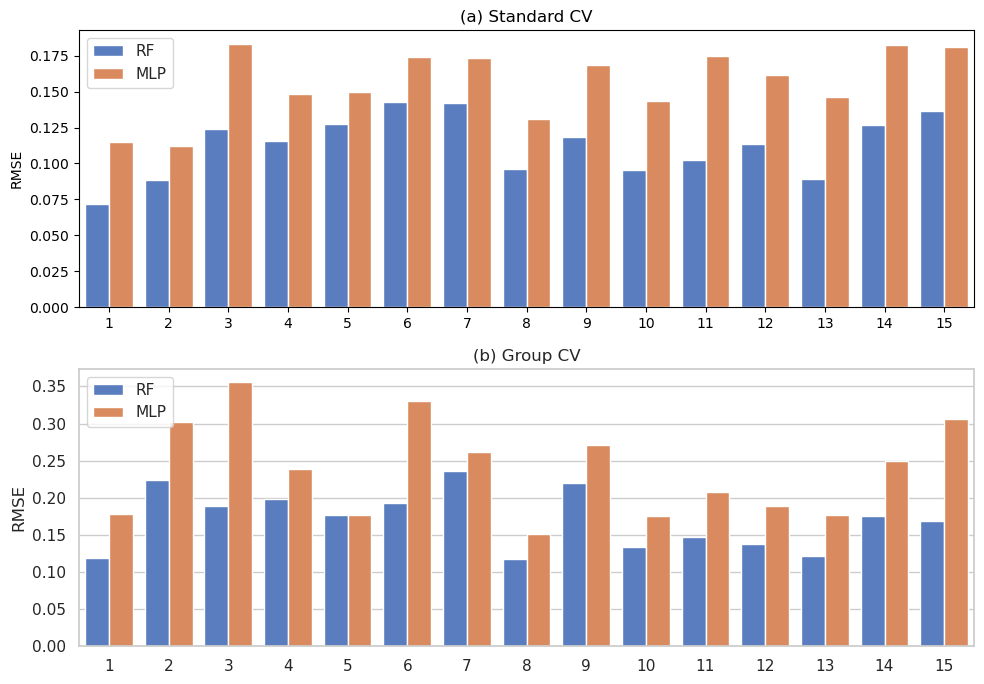

In [5]:
# rmse
titles = ['(a) Standard CV', '(b) Group CV']

fig = plt.figure(figsize=(10, 7))

for ii in range(2):
    fig.add_subplot(2, 1, ii+1)
    metplot = cv_eval[:, 0, 1, :, ii] # 15 clusters; rmse; test; rf/mlp; standard/group
    
    groups = [f'{i+1}' for i in range(metplot.shape[0])]
    bars = ['RF', 'MLP']
    data = []
    
    for i, group in enumerate(groups):
        for j, bar in enumerate(bars):
            data.append([group, bar, metplot[i, j]])
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=['Group', 'Bar', 'Value'])
    
    # Create the plot using seaborn
    sns.set(style="whitegrid")
    ax = sns.barplot(data=df, x='Group', y='Value', hue='Bar', palette='muted')
    
    # Set the axis labels and title
    ax.set_xlabel("")
    ax.set_ylabel("RMSE")
    ax.set_title(titles[ii])
    
    # Adjust the legend
    plt.legend(loc='upper left')

    # plt.xticks(rotation=45)  # Rotate group labels for better readability

plt.tight_layout()
plt.savefig('SBE_RFandMLP_test_RMSE_bar.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

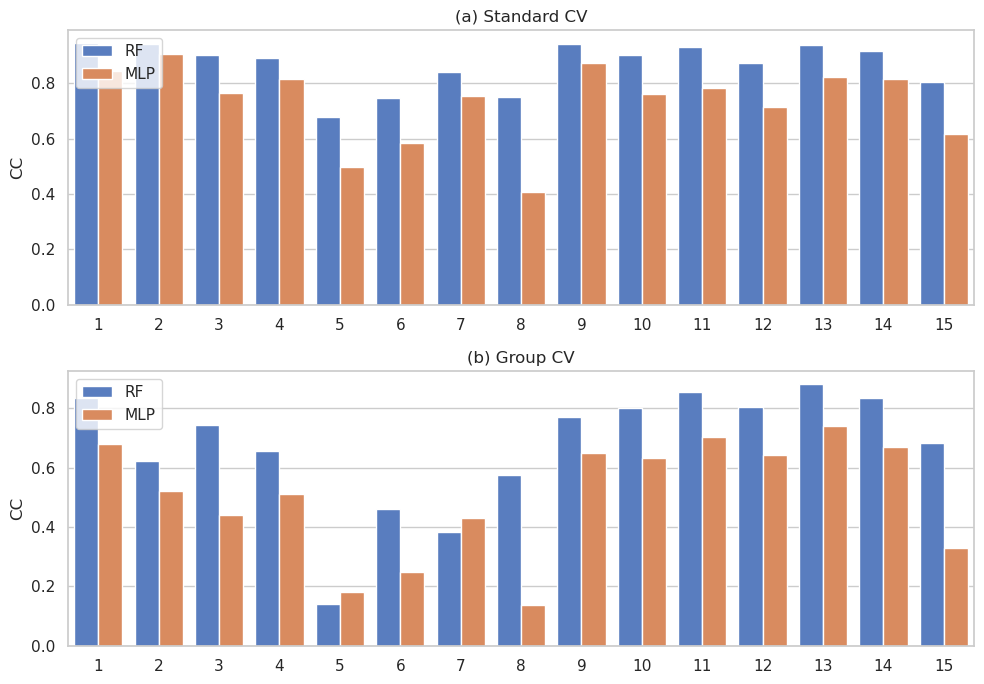

In [6]:
# cc

titles = ['(a) Standard CV', '(b) Group CV']

fig = plt.figure(figsize=(10, 7))

for ii in range(2):
    fig.add_subplot(2, 1, ii+1)
    metplot = cv_eval[:, 1, 1, :, ii] # 15 clusters; cc; test; rf/mlp; standard/group
    
    groups = [f'{i+1}' for i in range(metplot.shape[0])]
    bars = ['RF', 'MLP']
    data = []
    
    for i, group in enumerate(groups):
        for j, bar in enumerate(bars):
            data.append([group, bar, metplot[i, j]])
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=['Group', 'Bar', 'Value'])
    
    # Create the plot using seaborn
    sns.set(style="whitegrid")
    ax = sns.barplot(data=df, x='Group', y='Value', hue='Bar', palette='muted')
    
    # Set the axis labels and title
    ax.set_xlabel("")
    ax.set_ylabel("CC")
    ax.set_title(titles[ii])
    
    # Adjust the legend
    plt.legend(loc='upper left')

    # plt.xticks(rotation=45)  # Rotate group labels for better readability

plt.tight_layout()
plt.savefig('SBE_RFandMLP_test_CC_bar.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

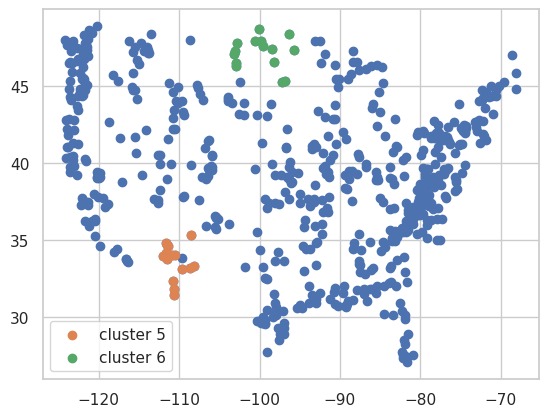

In [7]:
## where is cluster 5 and 6

plt.scatter(df_info['lon_cen'], df_info['lat_cen'])
for c in [5, 6]:
    ind = df_cluster["clusters"].values==c-1
    plt.scatter(df_info['lon_cen'].values[ind], df_info['lat_cen'].values[ind], label=f'cluster {c}')

plt.legend()
plt.show()

# Spatial distribution of metrics using group CV

## recover basin information since it is not saved in the CV output file

In [8]:
file = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/LargeSampleEmulator_exps_out/basin_id_forinput.gz'
df_basinid = pd.read_csv(file, compression='gzip')

clusters = np.nan * np.zeros(len(df_basinid))
for i in range(len(df_info)):
    indi = df_basinid['basin_id'].values == i
    clusters[indi] = df_cluster.iloc[i]['clusters']

In [9]:

def get_group_cv_indices(df_basinid, nfold=5, rndseed=1234567890):

    random.seed(rndseed)
    np.random.seed(rndseed)

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=nfold)

    # Dictionary to store train and test indices
    group_cv_indices = {}

    # Cross-validation process to save indices
    # does not depend on random seeds
    for fold, (train_index, test_index) in enumerate(group_kfold.split(df_basinid, groups=df_basinid['basin_num'])):
        
        train_basin = np.unique(df_basinid.iloc[train_index]['basin_id'].values)
        test_basin = np.unique(df_basinid.iloc[test_index]['basin_id'].values)

        group_cv_indices[fold] = {'train_index': train_index, 'test_index': test_index, 'train_index_raw': df_basinid.iloc[train_index].index, 'test_index_raw': df_basinid.iloc[test_index].index} 
    return group_cv_indices

# Get the indices
nfold = 5
group_cv_indices_all = []


for usecluster in range(15): # 0-14: 15 clusters
    ind2 = clusters == usecluster
    df_basinid_c = df_basinid[ind2]
    group_cv_indices = get_group_cv_indices(df_basinid_c, nfold)

    group_cv_indices_all.append(group_cv_indices)

In [10]:

cv_est_2 = cv_est.copy()
trueindex = np.nan * np.zeros(cv_est_2.shape[1])
for i in range(15):
    group_cv_indices = group_cv_indices_all[i]
    indi = cv_est_2[0,:,0]==i
    falseindex_i = cv_est_2[0,:,1][indi]
    trueindex_i = np.nan * np.ones(len(falseindex_i))
    for j in range(5):
        ind1 = group_cv_indices[j]['test_index']
        ind2 = np.array(group_cv_indices[j]['test_index_raw'])
        if np.any( np.any(falseindex_i[ind1] - ind1 !=0) ):
            print('Error warning!')
        trueindex_i[ind1] = ind2
    trueindex[indi] = trueindex_i

for i in range(cv_est_2.shape[0]):
    cv_est_2[i, :, 1] = trueindex

In [11]:
met = np.nan * np.zeros([len(df_info), 2, cv_est_2.shape[0]]) # rmse/cc; ['RF standard', 'RF group', 'MLP standard', 'MLP group']

for i in range(len(df_info)):
    indi = np.where(df_basinid['basin_id'].values==i)[0]
    for j in range(cv_est_2.shape[0]):
        ddi = cv_est_2[j, indi, 2]
        met[i, 0, j] = get_rmse(cv_est_2[j, indi, 2],  cv_est_2[j, indi, 3])
        met[i, 1, j] = get_cc(cv_est_2[j, indi, 2],  cv_est_2[j, indi, 3])

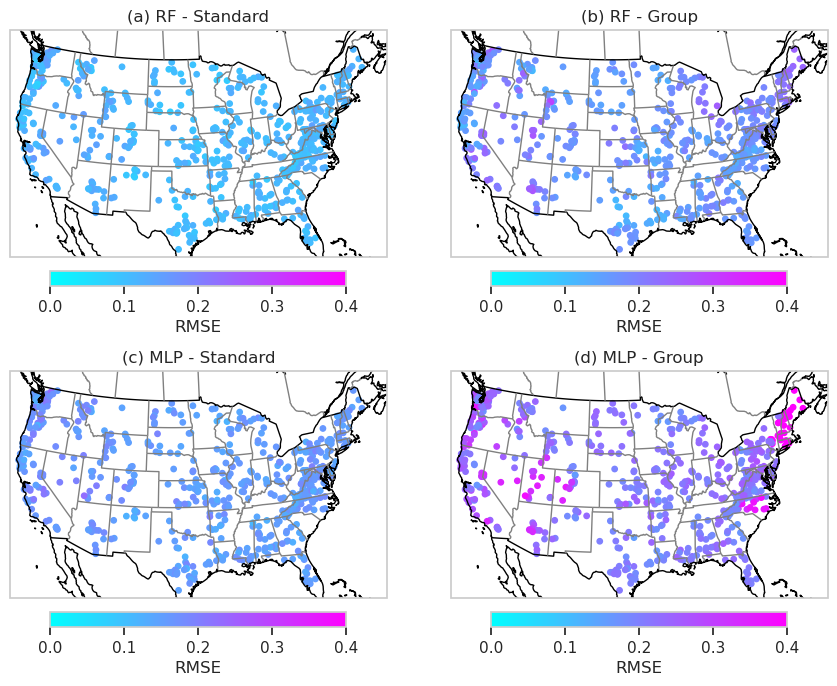

In [12]:
# plot rmse
lon = df_info['lon_cen'].values
lat = df_info['lat_cen'].values

title = ["(a) RF - Standard", "(b) RF - Group", 
         "(c) MLP - Standard", "(d) MLP - Group", ]
cmaps = ['cool', 'cool', 
         'cool', 'cool', 
         ]

fig = plt.figure(figsize=[9, 7])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()


for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 15, met[:, 0, i], cmap=cmaps[i], vmin=0, vmax=0.4, transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='bottom', shrink=0.7, label='RMSE', pad=0.05)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')
    # ax.spines['geo'].set_visible(False)


plt.tight_layout()
plt.savefig('SBE_RF_GPR_CV_RMSE_map.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

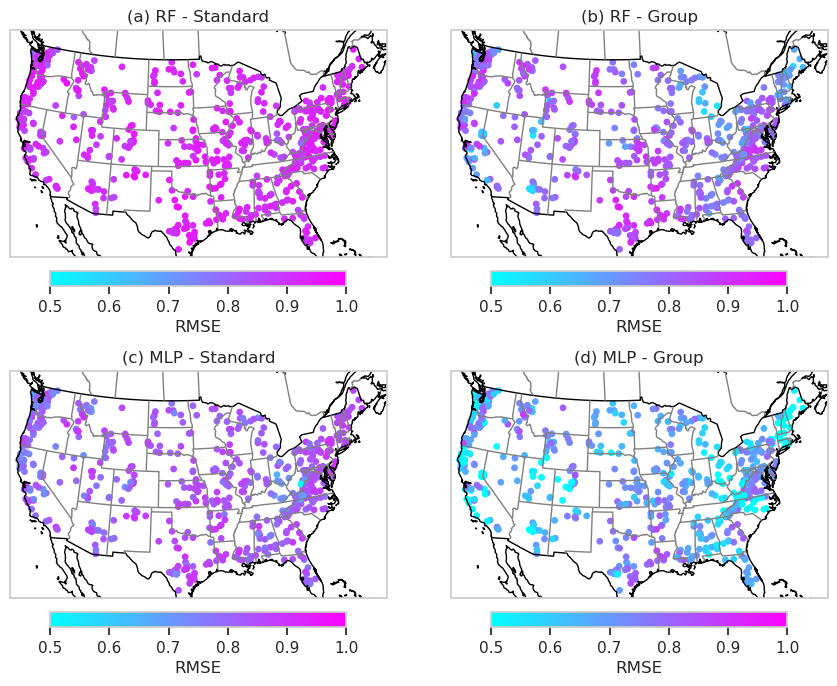

In [13]:
# plot rmse
lon = df_info['lon_cen'].values
lat = df_info['lat_cen'].values

title = ["(a) RF - Standard", "(b) RF - Group", 
         "(c) MLP - Standard", "(d) MLP - Group", ]
cmaps = ['cool', 'cool', 
         'cool', 'cool', 
         ]

fig = plt.figure(figsize=[9, 7])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()


for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 15, met[:, 1, i], cmap=cmaps[i], vmin=0.5, vmax=1, transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='bottom', shrink=0.7, label='RMSE', pad=0.05)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')
    # ax.spines['geo'].set_visible(False)


plt.tight_layout()
plt.savefig('SBE_RF_GPR_CV_CC_map.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()